In [1]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf


In [2]:
url1 = 'https://www.isyatirim.com.tr/tr-tr/analiz/hisse/Sayfalar/Temel-Degerler-Ve-Oranlar.aspx?endeks=01#page-1 '
response1 = requests.get(url1)

In [3]:
soup1 = bs(response1.text,'html.parser')
table1 = soup1.find('table',{ 'data-csvname':'temelozet'})

In [4]:
temelozet = pd.read_html(str(table1))
temelozet = pd.DataFrame(temelozet[0])

In [5]:
url2 = 'https://www.isyatirim.com.tr/tr-tr/analiz/hisse/Sayfalar/Temel-Degerler-Ve-Oranlar.aspx?endeks=01#page-6 '
response2 = requests.get(url2)

soup2 = bs(response2.text,'html.parser')
table2 = soup2.find('table',{ 'data-csvname':'temelperformans'})
hissePerf = pd.read_html(str(table2))
hissePerf = pd.DataFrame(hissePerf[0]) 
hissePerf = hissePerf[['Yıl İçi Getiri (%)']]
#Performans dosyasından sadece yıl içi getiri yüzdesi ile karşılaştırmak istedik


In [6]:
#Yıl içi getiri sütununu temel ozet tablosuna ekledik.
extracted_col = hissePerf["Yıl İçi Getiri (%)"]
temelozet = temelozet.join(extracted_col)


In [7]:
#Değerlerdeki virgül sorununu çözmek için değerler üzerinde işlem yaptık.
temelozet['Halka Açıklık Oranı (%)'] = pd.to_numeric(temelozet['Halka Açıklık Oranı (%)'])
temelozet['Halka Açıklık Oranı (%)'] = temelozet['Halka Açıklık Oranı (%)'].apply(lambda x: x/10 )
temelozet['Yıl İçi Getiri (%)'] = temelozet['Yıl İçi Getiri (%)'].apply(lambda x: x/100 )


In [8]:
# Sektörlere göre gruplandırma ve ortalama hesaplama
ortalama_halka_aciklik = temelozet.groupby('Sektör')['Halka Açıklık Oranı (%)'].mean()

# Gruplanmış verileri yeni bir veri çerçevesine dönüştürme
ortalama_df = pd.DataFrame({'Sektör': ortalama_halka_aciklik.index, 'Ortalama Halka Açıklık Oranı (%)': ortalama_halka_aciklik})

# Yeni veri çerçevesini kullanarak bar grafiği oluşturma
fig_2 = px.bar(
    x=ortalama_df['Sektör'],
    y=ortalama_df['Ortalama Halka Açıklık Oranı (%)'].apply(lambda x: x/10),
    width=1000,
    height=500,
    title='Sektör/Ortalama Halka Açıklık Oranı',
    labels={'x': 'Sektör', 'y': 'Ortalama Halka Açıklık Oranı (%)'},
    color=ortalama_df['Sektör'],
    color_discrete_sequence=px.colors.qualitative.Dark24
)
fig_2.update_layout(
    font=dict(size=16) 
)
fig_2.update_xaxes(tickfont=dict(size=16)) 
fig_2.update_yaxes(tickfont=dict(size=16)) 


fig_2.show()

In [9]:
# Sektörlere göre gruplandırma ve ortalama hesaplama
ortalama_yil_ici_getiri = temelozet.groupby('Sektör')['Yıl İçi Getiri (%)'].mean()

# Gruplanmış verileri yeni bir veri çerçevesine dönüştürme
ortalama_df = pd.DataFrame({'Sektör': ortalama_yil_ici_getiri.index, 'Ortalama Yıl İçi Getiri (%)': ortalama_yil_ici_getiri})

# Yeni veri çerçevesini kullanarak bar grafiği oluşturma
fig_3 = px.bar(
    x=ortalama_df['Sektör'],
    y=ortalama_df['Ortalama Yıl İçi Getiri (%)'],
    width=1000,
    height=500,
    title='Sektör/Ortalama Yıl İçi Getiri (%)(15.05.2023)',
    color=ortalama_df['Ortalama Yıl İçi Getiri (%)'].apply(lambda x: 'pozitif' if x >= 0 else 'negatif'),
    color_discrete_map={'pozitif':'green', 'negatif':'red'},
    labels={'x': 'Sektör', 'y': 'Ortalama Yıl İçi Getiri (%)'}
)
fig_3.update_layout(
    font=dict(size=16) 
)
fig_3.update_xaxes(tickfont=dict(size=16)) 
fig_3.update_yaxes(tickfont=dict(size=16)) 

fig_3.show()

In [10]:
temelozet['Piyasa Değeri (mn TL)'] = temelozet['Piyasa Değeri (mn TL)'].apply(lambda x: ''.join(filter(str.isdigit, str(x)))).astype(float)


ortalama_piyasa_degeri = temelozet.groupby('Sektör')['Piyasa Değeri (mn TL)'].mean()
ortalama = ortalama_piyasa_degeri.mean()

ortalama_df = pd.DataFrame({'Sektör': ortalama_piyasa_degeri.index, 'Ortalama Piyasa Değeri (mn TL)': ortalama_piyasa_degeri})
ortalama_df['Renk'] = ortalama_df['Ortalama Piyasa Değeri (mn TL)'].apply(lambda x: 'Genel Ortalamanın Altı' if x < ortalama else 'Genel Ortalamanın Üstü')

fig_4 = px.bar(
    x=ortalama_df['Sektör'],
    y=ortalama_df['Ortalama Piyasa Değeri (mn TL)'],
    width=1000,
    height=500,
    title='Sektör/Ortalama Piyasa Değeri',
    color=ortalama_df['Renk'],
    color_discrete_map={'Genel Ortalamanın Altı': 'lightgreen', 'Genel Ortalamanın Üstü': 'green'},
    labels={'x': 'Sektör', 'y': 'Ortalama Piyasa Değeri (mn TL)'}
)
fig_4.update_layout(
    font=dict(size=16),
    legend=dict(
        x=1,
        y=-1,
        bgcolor='rgba(0,0,0,0)' 
    )
)

fig_4.update_xaxes(tickfont=dict(size=16)) 
fig_4.update_yaxes(tickfont=dict(size=16)) 

fig_4.show()

In [11]:
sirketler = ['BIMAS.IS', 'MGROS.IS', 'SOKM.IS', 'TUKAS.IS', 'ULUUN.IS', 'XU100.IS']
veriler = pd.DataFrame()
for sirket in sirketler:
    data = yf.download(sirket, start='2021-01-01', end='2021-12-31')
    data = data[['Adj Close']]
    data.columns = [sirket]
    if veriler.empty:
        veriler = data
    else:
        veriler = veriler.join(data)

veriler

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BIMAS.IS,MGROS.IS,SOKM.IS,TUKAS.IS,ULUUN.IS,XU100.IS
Date,,,,,,
2021-01-04,69.055031,44.560001,12.846131,5.333333,4.692737,1495.400024
2021-01-05,67.854454,43.980000,13.034028,5.294444,4.772887,1489.599976
2021-01-06,67.943382,44.139999,12.895577,5.316666,4.857043,1505.400024
2021-01-07,68.476967,43.820000,12.935135,5.305555,4.897118,1522.199951
2021-01-08,69.618256,44.540001,13.835056,5.400000,4.885096,1540.599976
...,...,...,...,...,...,...
2021-12-24,63.502342,39.340000,13.020000,4.083333,6.013757,1891.300049
2021-12-27,62.045868,38.779999,13.390000,4.038888,5.868848,1897.099976
2021-12-28,60.783585,37.220001,13.120000,3.966666,5.696767,1850.500000


In [20]:
norm1 = veriler.iloc[0,0]
norm2 = veriler.iloc[0,1]
norm3 = veriler.iloc[0,2]
norm4 = veriler.iloc[0,3]
norm5 = veriler.iloc[0,4]
norm6 = veriler.iloc[0,5]

veriler['Normalize BIMAS.IS'] =veriler[['BIMAS.IS']]/norm1
veriler['Normalize MGROS.IS'] =veriler[['MGROS.IS']]/norm2
veriler['Normalize SOKM.IS'] =veriler[['SOKM.IS']]/norm3
veriler['Normalize TUKAS.IS'] =veriler[['TUKAS.IS']]/norm4
veriler['Normalize ULUUN.IS'] =veriler[['ULUUN.IS']]/norm5
veriler['Normalize XU100.IS'] =veriler[['XU100.IS']]/norm6

normalize_veriler = veriler[['Normalize BIMAS.IS', 'Normalize MGROS.IS', 'Normalize SOKM.IS', 'Normalize TUKAS.IS', 'Normalize ULUUN.IS', 'Normalize XU100.IS']]
normalize_veriler

,Normalize BIMAS.IS,Normalize MGROS.IS,Normalize SOKM.IS,Normalize TUKAS.IS,Normalize ULUUN.IS,Normalize XU100.IS
Date,,,,,,
2021-01-04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2021-01-05,0.982614,0.986984,1.014627,0.992708,1.017080,0.996121
2021-01-06,0.983902,0.990574,1.003849,0.996875,1.035013,1.006687
2021-01-07,0.991629,0.983393,1.006928,0.994792,1.043553,1.017922
2021-01-08,1.008156,0.999551,1.076982,1.012500,1.040991,1.030226
...,...,...,...,...,...,...
2021-12-24,0.919590,0.882855,1.013535,0.765625,1.281503,1.264745
2021-12-27,0.898499,0.870287,1.042337,0.757292,1.250624,1.268624
2021-12-28,0.880219,0.835278,1.021319,0.743750,1.213954,1.237462


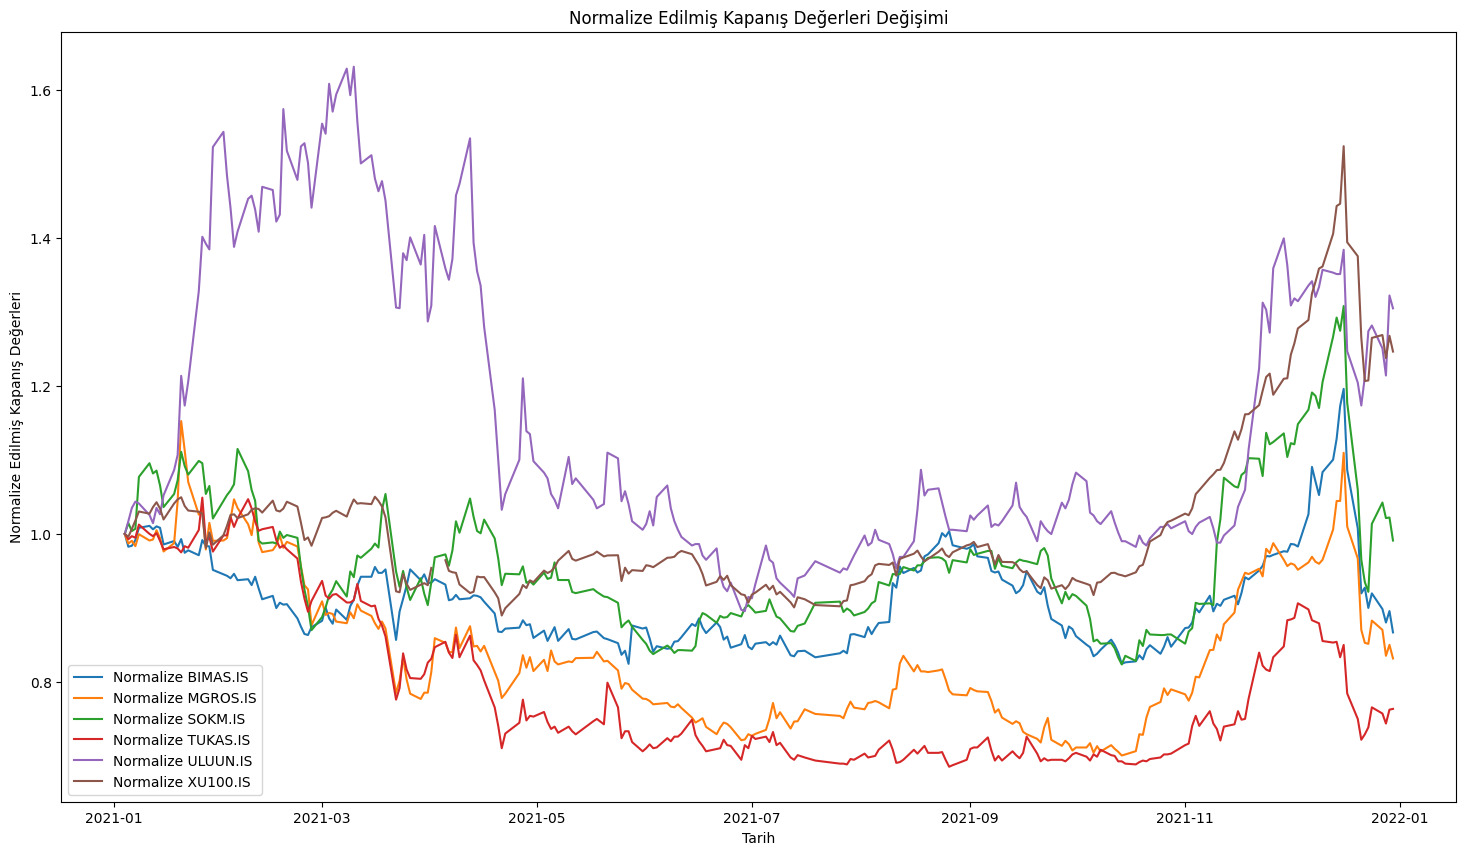

In [13]:
# Line grafiğini çiz
plt.figure(figsize=(18, 10))
for sirket in normalize_veriler.columns:
    plt.plot(normalize_veriler.index, normalize_veriler[sirket], label=sirket)
plt.xlabel('Tarih')
plt.ylabel('Normalize Edilmiş Kapanış Değerleri')
plt.title('Normalize Edilmiş Kapanış Değerleri Değişimi')
plt.legend()
plt.show()

In [29]:
normalize_veriler['ay_yıl']=normalize_veriler.index.strftime('%Y-%m')
normalize_veriler

<ipython-input-29-9f28f83b84d9>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Normalize BIMAS.IS,Normalize MGROS.IS,Normalize SOKM.IS,Normalize TUKAS.IS,Normalize ULUUN.IS,Normalize XU100.IS,ay_yıl
Date,,,,,,,
2021-01-04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2021-01
2021-01-05,0.982614,0.986984,1.014627,0.992708,1.017080,0.996121,2021-01
2021-01-06,0.983902,0.990574,1.003849,0.996875,1.035013,1.006687,2021-01
2021-01-07,0.991629,0.983393,1.006928,0.994792,1.043553,1.017922,2021-01
2021-01-08,1.008156,0.999551,1.076982,1.012500,1.040991,1.030226,2021-01
...,...,...,...,...,...,...,...
2021-12-24,0.919590,0.882855,1.013535,0.765625,1.281503,1.264745,2021-12
2021-12-27,0.898499,0.870287,1.042337,0.757292,1.250624,1.268624,2021-12
2021-12-28,0.880219,0.835278,1.021319,0.743750,1.213954,1.237462,2021-12


In [31]:
aylık_normalize=normalize_veriler.pivot_table(index='ay_yıl',aggfunc='last')
aylık_normalize

,Normalize BIMAS.IS,Normalize MGROS.IS,Normalize SOKM.IS,Normalize TUKAS.IS,Normalize ULUUN.IS,Normalize XU100.IS
ay_yıl,,,,,,
2021-01,0.951303,0.990574,1.020785,0.976042,1.522630,0.985355
2021-02,0.873956,0.876571,0.869900,0.909375,1.440649,0.983951
2021-03,0.933453,0.785458,0.903772,0.826042,1.286934,0.930654
2021-04,0.859412,0.814632,0.931486,0.753125,1.098156,0.934733
2021-05,0.872097,0.777379,0.856813,0.706250,1.005517,0.949913
2021-06,0.847550,0.729354,0.903772,0.710417,0.914808,0.906981
2021-07,0.864597,0.765260,0.889762,0.694792,0.970777,0.931456
2021-08,0.979831,0.781867,0.961379,0.694792,1.003587,0.984419
2021-09,0.871415,0.707361,0.918564,0.702083,1.067276,0.940484


In [32]:
bist100 = aylık_normalize[['Normalize XU100.IS']].copy()
bist100

,Normalize XU100.IS
ay_yıl,
2021-01,0.985355
2021-02,0.983951
2021-03,0.930654
2021-04,0.934733
2021-05,0.949913
2021-06,0.906981
2021-07,0.931456
2021-08,0.984419
2021-09,0.940484


In [33]:
aylık_normalize.drop('Normalize XU100.IS', axis=1, inplace=True)
aylık_normalize

,Normalize BIMAS.IS,Normalize MGROS.IS,Normalize SOKM.IS,Normalize TUKAS.IS,Normalize ULUUN.IS
ay_yıl,,,,,
2021-01,0.951303,0.990574,1.020785,0.976042,1.522630
2021-02,0.873956,0.876571,0.869900,0.909375,1.440649
2021-03,0.933453,0.785458,0.903772,0.826042,1.286934
2021-04,0.859412,0.814632,0.931486,0.753125,1.098156
2021-05,0.872097,0.777379,0.856813,0.706250,1.005517
2021-06,0.847550,0.729354,0.903772,0.710417,0.914808
2021-07,0.864597,0.765260,0.889762,0.694792,0.970777
2021-08,0.979831,0.781867,0.961379,0.694792,1.003587
2021-09,0.871415,0.707361,0.918564,0.702083,1.067276


In [34]:
aylık_normalize['BIST5 Normalizasyon'] = aylık_normalize.mean(axis=1)
aylık_normalize

,Normalize BIMAS.IS,Normalize MGROS.IS,Normalize SOKM.IS,Normalize TUKAS.IS,Normalize ULUUN.IS,BIST5 Normalizasyon
ay_yıl,,,,,,
2021-01,0.951303,0.990574,1.020785,0.976042,1.522630,1.092267
2021-02,0.873956,0.876571,0.869900,0.909375,1.440649,0.994090
2021-03,0.933453,0.785458,0.903772,0.826042,1.286934,0.947132
2021-04,0.859412,0.814632,0.931486,0.753125,1.098156,0.891362
2021-05,0.872097,0.777379,0.856813,0.706250,1.005517,0.843611
2021-06,0.847550,0.729354,0.903772,0.710417,0.914808,0.821180
2021-07,0.864597,0.765260,0.889762,0.694792,0.970777,0.837038
2021-08,0.979831,0.781867,0.961379,0.694792,1.003587,0.884291
2021-09,0.871415,0.707361,0.918564,0.702083,1.067276,0.853340


In [35]:
aylık_normalize=aylık_normalize[['BIST5 Normalizasyon']]
aylık_normalize

,BIST5 Normalizasyon
ay_yıl,
2021-01,1.092267
2021-02,0.994090
2021-03,0.947132
2021-04,0.891362
2021-05,0.843611
2021-06,0.821180
2021-07,0.837038
2021-08,0.884291
2021-09,0.853340


In [36]:
aylık_normalize=aylık_normalize.merge(bist100,left_index=True,right_index=True)
aylık_normalize

,BIST5 Normalizasyon,Normalize XU100.IS
ay_yıl,,
2021-01,1.092267,0.985355
2021-02,0.994090,0.983951
2021-03,0.947132,0.930654
2021-04,0.891362,0.934733
2021-05,0.843611,0.949913
2021-06,0.821180,0.906981
2021-07,0.837038,0.931456
2021-08,0.884291,0.984419
2021-09,0.853340,0.940484


In [38]:
graf= px.line(aylık_normalize,y=['BIST5 Normalizasyon','Normalize XU100.IS'])
# Grafiğin görüntüsünü ayarlama
graf.update_layout(
    title="BIST5 vs. BIST100",
    xaxis_title="Tarih",
    yaxis_title="Normalize edilmiş değerler",
    width=1700,
    height=800,
    showlegend=True
)
# X eksenini ay formatında gösterme
graf.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y"
)

# Grafiği gösterme
graf.show()